### Importación de librerías

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dateutil import parser
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
mmscaler = MinMaxScaler()
sscaler = StandardScaler()
rscaler = RobustScaler()
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
import gc
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

### Lectura del archivo excel con la información de los clientes

In [2]:
df_tabla_final = pd.read_excel("archivos_entrada_script/tabla_final.xlsx", sheet_name="Hoja2", dtype={"CODIGOCLIE":str})
df_tabla_final["CODIGOCLIE"] = df_tabla_final["CODIGOCLIE"].astype("string")
df_tabla_final = df_tabla_final.iloc[:,2:6]
df_tabla_final

,Nombre,CIIU,CODIGOCLIE,Mult. de potencias
0,LA INDUSTRIA HARINERA S.A,C1061.11,1401867926,1100.0
1,CONFITECA,C1073.21,1490000744,1100.0
2,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,1490000688,1100.0
3,"AC BEBIDAS, S. DE R.L. DE C.V.",C1104.01,1490001175,400.0
4,S.J. JERSEY ECUATORIANO C.A.,C1311.02,1490000515,800.0
...,...,...,...,...
209,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,1410020880,1140.0
210,ECUATORIANA DE ARTEFACTOS S.A. ECASA,C2750.01,1490000693,1.0
211,INTEXDECOR S.A.,G4641.11,1490001644,1000.0
212,INTELA INDUSTRIA TEXTIL LATINOAMERICANA CIA. L...,C1312.01,1410062892,1100.0


In [3]:
clientes_unicos = df_tabla_final["CODIGOCLIE"].unique()
print(clientes_unicos)

<StringArray>
['1401867926', '1490000744', '1490000688', '1490001175', '1490000515',
 '1401337167', '1490002225', '1401582655', '1490001247', '1401282968',
 ...
 '1401229975', '1401954998', '1490000719', '1401940609', '1410026628',
 '1410020880', '1490000693', '1490001644', '1410062892', '1490002155']
Length: 214, dtype: string


In [5]:
def intentar_abrir_archivo_datos(path_archivo):

    df_archivo_telem_tab = pd.DataFrame([1,2,3], columns=["prueba"])
    df_archivo_telem_pc = pd.DataFrame([1,2,3], columns=["prueba"])
    df_archivo_telem_c = pd.DataFrame([1,2,3], columns=["prueba"])

    # Intentar leer el archivo con separador 'tab'
    try:
        #print("Leyendo con tab")
        df_archivo_telem_tab = pd.read_csv(path_archivo,
                                            sep="\t",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            ) 
    except:
        pass

    # Intentar leer el archivo con separador 'punto y coma'
    try:
        #print("Leyendo con ;")
        df_archivo_telem_pc = pd.read_csv(path_archivo,
                                            sep=";",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            #encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            )

    except:
        pass

    # Intentar leer el archivo con separador 'coma'
    try:
        #print("Leyendo con ,")
        df_archivo_telem_c = pd.read_csv(path_archivo,
                                            sep=",",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            #encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            )

    except:
        pass



    if len(df_archivo_telem_tab.columns) > 1:
        df_archivo_telem = df_archivo_telem_tab.copy()
    elif len(df_archivo_telem_pc.columns) > 1:
        df_archivo_telem = df_archivo_telem_pc.copy()
    else:
        df_archivo_telem = df_archivo_telem_c.copy()

    return df_archivo_telem

### 1. Extracción de los archivos de cada grupo de clientes

#### 1.1 Extracción de los archivos con las mediciones mensuales del primer grupo de clientes

Estos clientes están clasificados por CUEN, y el formato de sus archivos varían, el procedimiento a seguir será:
1. Iterar sobre cada código de cliente
2. Buscar sus archivos de datos mensuales
3. Unificar todos en un solo archivo
4. El identificador a usar es el código de cliente

In [6]:
mediciones_clientes_g1 = r"mediciones_originales/mediciones_por_mes_g1"
archivos_mediciones_g1 = list(os.scandir(mediciones_clientes_g1))
columnas_extraer_g1 = ["Fecha","Demanda activa DEL","Demanda reactiva DEL"]

In [7]:
clientes_unicos_g1 = set()

for medicion in archivos_mediciones_g1:
    cliente = medicion.name.split('-')[1]
    clientes_unicos_g1.add(cliente)

print(f"Clientes único encontrados en la carpeta de mediciones del grupo uno: {len(clientes_unicos_g1)}")

Clientes único encontrados en la carpeta de mediciones del grupo uno: 314


In [8]:
# Iterar sobre cada cliente
for cliente in tqdm(clientes_unicos_g1, desc="Procesando clientes del grupo 01"):
    datos_cliente = []

    # Iterar sobre cada archivo de medicion del grupo 01
    for medicion in archivos_mediciones_g1:
        if cliente == medicion.name.split("-")[1]:
            df_cliente = intentar_abrir_archivo_datos(f"{mediciones_clientes_g1}/{medicion.name}")
            datos_cliente.extend(df_cliente[columnas_extraer_g1].values)

    df_datos_anual_cliente = pd.DataFrame(datos_cliente, columns=columnas_extraer_g1)
    df_datos_anual_cliente.to_csv(f"mediciones_por_anio/g1_perfil_carga_anual-{cliente}-2023.csv", index=False)

Procesando clientes del grupo 01: 100%|██████████| 314/314 [03:41<00:00,  1.42it/s]


#### 1.2 Extracción de los archivos con las mediciones mensuales del segundo grupo de clientes

De estos clientes tenemos carpetas con sus mediciones por mes, no existe tabla de excel inicial, se procederá a realizar lo siguiente:
1. Iterar sobre cada carpeta (cliente)
2. Obtener los datos de sus 12 meses
3. Unificar en un único archivo anual
4. Se usará el nombre del cliente como identificador

In [9]:
mediciones_clientes_g2 = "mediciones_originales/mediciones_por_mes_g2"
archivos_mediciones_g2 = list(os.scandir(mediciones_clientes_g2))
columnas_extraer_g2 = ["Fecha", "SE (KVah)"]

In [10]:
print(f"Clientes único encontrados en la carpeta de mediciones del grupo uno: {len(archivos_mediciones_g2)}")

Clientes único encontrados en la carpeta de mediciones del grupo uno: 75


In [11]:
# Iterar sobre cada cliente
for archivos_cliente in tqdm(archivos_mediciones_g2, desc="Procesando clientes del grupo 02"):
    nombre_cli = archivos_cliente.name
    df_concat = pd.DataFrame()

    # Obtener los archivos de las mediciones mensuales del cliente
    mediciones_mensuales_cliente = os.scandir(rf"{mediciones_clientes_g2}/{nombre_cli}")

    for medicion in mediciones_mensuales_cliente:
        medicion_mensual = pd.read_csv(rf"{mediciones_clientes_g2}/{nombre_cli}/{medicion.name}", sep=";", skiprows=2, encoding='ISO-8859-1')
        medicion_mensual = medicion_mensual[columnas_extraer_g2]
        df_concat = pd.concat([df_concat, medicion_mensual])

    df_concat.to_csv(rf"mediciones_por_anio/g2_perfil_carga_anual-{nombre_cli}-2023.csv", index=False)

Procesando clientes del grupo 02: 100%|██████████| 75/75 [00:30<00:00,  2.47it/s]


### 2. Preprocesamiento de los datos

Ahora tenemos todos los datos unificados anualmente por cada cliente, tenemos que limpiar y preprocesar, realizar las siguientes tareas:
1. Calcular la potencia aparente (resultado de aplicar teorema pitágoras sobre potencia activa y reactiva)
2. Separar la columna 'fecha' en dos columnas 'fecha' y 'hora', fecha va a tener formato 'año/mes/dia' y hora el formato 'hh:mm'
3. Excluir aquellos registros que correspondan a fechas de sábado, domingo o días de feriado nacional
4. Normalizar los datos para que todos estén en la misma escala

In [12]:
feriados_nacionales = ["2/7/2023", "20/2/2023", "21/2/2023", "7/4/2023", "1/5/2023", \
                       "26/5/2023", "11/8/2023", "9/10/2023", "2/10/2023", "3/10/2023", "25/12/2023"]
feriados_nacionales = pd.to_datetime(feriados_nacionales, format='%d/%m/%Y')

dict_meses = {"01": "Enero",
              "02": "Febrero",
              "03": "Marzo",
              "04": "Abril",
              "05": "Mayo",
              "06": "Junio",
              "07": "Julio",
              "08": "Agosto",
              "09": "Septiembre",
              "10": "Octubre",
              "11": "Noviembre",
              "12": "Diciembre"}

print(list(dict_meses.keys()))
print(feriados_nacionales)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
DatetimeIndex(['2023-07-02', '2023-02-20', '2023-02-21', '2023-04-07',
               '2023-05-01', '2023-05-26', '2023-08-11', '2023-10-09',
               '2023-10-02', '2023-10-03', '2023-12-25'],
              dtype='datetime64[ns]', freq=None)


In [13]:
def fecha_formato_unico(fecha_str):

    # Poner separador único el '/' y año únicamente 2023
    fecha_str = fecha_str.replace('-','/').replace('2024','2023')

    if len(fecha_str.split('/')[0]) == 4: # Cuando el formato es año/mes/día
        return fecha_str
    elif len(fecha_str.split('/')[0]) != 4: # Cuando el formato es día/mes/año
        seps = fecha_str.split('/')
        return f"{seps[-1]}/{seps[1]}/{seps[0]}"
    

def recortar_valores_atipicos(df, columna_valor):
    # Calcular los cuartiles y el IQR
    Q1 = df[columna_valor].quantile(0.25)
    Q3 = df[columna_valor].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites superior e inferior
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Aplicar el recorte
    df[columna_valor] = df[columna_valor].clip(lower=limite_inferior, upper=limite_superior)

In [47]:
mediciones_anuales_clientes = "mediciones_por_anio"
archivos_mediciones_anuales = list(os.scandir(mediciones_anuales_clientes))

2.1 - Transformación columna fecha archivos anuales grupo 01

In [48]:
for archivo in tqdm(archivos_mediciones_anuales, desc="Procesando archivos con mediciones anuales"):

    if archivo.name.startswith("g1"):

        # Leer el archivo con las mediciones de todo el año
        df_archivo_g1 = pd.read_csv(f"{mediciones_anuales_clientes}/{archivo.name}")

        # Transformar columna fecha a cadena
        df_archivo_g1["Fecha"] = df_archivo_g1["Fecha"].astype("string")

        # Eliminar los valores nulos en la columna 'Fecha'
        df_archivo_g1 = df_archivo_g1.dropna(subset="Fecha")

        # Separar para obtener columna Hora
        df_archivo_g1["Hora"] = df_archivo_g1["Fecha"].apply(lambda x: x.split()[1].strip())

        # Separar para obtener columna Fecha
        df_archivo_g1["Fecha"] = df_archivo_g1["Fecha"].apply(lambda x: x.split()[0].strip())

        # Transformar la columna Fecha a un formato único
        df_archivo_g1["Fecha"] = df_archivo_g1["Fecha"].apply(fecha_formato_unico)

        # Debido a que a veces se ponen datos del 2024 para reemplazar los faltantes del 2023
        # debemos descartar la fecha 29 de febrero, pues en 2023 no existe
        df_archivo_g1 = df_archivo_g1[df_archivo_g1["Fecha"] != "2023/02/29"]
        
        # Eliminar duplicados y conservar el original del 2023
        df_archivo_g1["Fecha-Hora"] = df_archivo_g1["Fecha"] + " " + df_archivo_g1["Hora"]
        df_archivo_g1 = df_archivo_g1.drop_duplicates(subset="Fecha-Hora", keep="first")

        # Transformar columna Fecha a datetime
        df_archivo_g1["Fecha"] = pd.to_datetime(df_archivo_g1["Fecha"], format='%Y/%m/%d')

        # Obtener la potencia aparente
        df_archivo_g1["Potencia_aparente"] = np.sqrt((df_archivo_g1["Demanda activa DEL"]**2) + (df_archivo_g1["Demanda reactiva DEL"]**2))

        # Eliminar días feriados y días de fin de semana
        df_archivo_g1 = df_archivo_g1[~df_archivo_g1['Fecha'].isin(feriados_nacionales) & ~df_archivo_g1['Fecha'].dt.weekday.isin([5, 6])]

        # Interpolar valores nulos usando una función polinomial
        df_archivo_g1["Potencia_aparente"] = df_archivo_g1["Potencia_aparente"].interpolate(method='polynomial', order=3)

        # Conservar solo las columnas de interés
        df_archivo_g1 = df_archivo_g1[["Fecha", "Hora", "Potencia_aparente"]]

        # Escalar las mediciones
        df_archivo_g1["Potencia_aparente_escalada"] = mmscaler.fit_transform(df_archivo_g1[["Potencia_aparente"]])

        # Guardar los nuevos archivos en otra carpeta
        df_archivo_g1.to_csv(f"mediciones_por_anio_limpias/perfil_carga_anual_limpio-{archivo.name.split('-')[1]}-2023.csv", index=False)

Procesando archivos con mediciones anuales: 100%|██████████| 389/389 [00:48<00:00,  8.08it/s]


2.2 - Transformación columna fecha archivos anuales grupo 02

In [49]:
for archivo in tqdm(archivos_mediciones_anuales, desc="Procesando archivos con mediciones anuales"):

    if archivo.name.startswith("g2"):

        # Leer el archivo con las mediciones de todo el año
        df_archivo_g2 = pd.read_csv(f"{mediciones_anuales_clientes}/{archivo.name}")

        # Transformar columna fecha a cadena
        df_archivo_g2["Fecha"] = df_archivo_g2["Fecha"].astype("string")

        # Eliminar registros que contienen el total
        df_archivo_g2 = df_archivo_g2[~df_archivo_g2["Fecha"].str.contains("Total")]

        # Eliminar los valores nulos en la columna 'Fecha'
        df_archivo_g2 = df_archivo_g2.dropna(subset="Fecha")

        # Separar para obtener columna Hora
        df_archivo_g2["Hora"] = df_archivo_g2["Fecha"].apply(lambda x: x.split()[1].strip())

        # Separar para obtener columna Fecha
        df_archivo_g2["Fecha"] = df_archivo_g2["Fecha"].apply(lambda x: x.split()[0].strip())

        # Eliminar duplicados y conservar el original del 2023
        df_archivo_g2["Fecha-Hora"] = df_archivo_g2["Fecha"] + " " + df_archivo_g2["Hora"]
        df_archivo_g2["Fecha-Hora"] = pd.to_datetime(df_archivo_g2["Fecha-Hora"], yearfirst=True)
        df_archivo_g2 = df_archivo_g2.drop_duplicates(subset="Fecha-Hora", keep="first")

        # Restar un timedelta de 15 a todas las fechas (Solo en este caso por que la ultima fecha)
        # se pasa al siguiente mes
        df_archivo_g2["Fecha-Hora"] = df_archivo_g2["Fecha-Hora"] - pd.Timedelta(minutes=15)

        # Separar nuevamente para obtener columna Hora
        df_archivo_g2["Hora"] = df_archivo_g2["Fecha-Hora"].astype("string").apply(lambda x: x.split()[1][:-3].strip())

        # Separar nuevamente para obtener columna Fecha
        df_archivo_g2["Fecha"] = df_archivo_g2["Fecha-Hora"].astype("string").apply(lambda x: x.split()[0].strip())

        # Transformar la columna Fecha a un formato único
        df_archivo_g2["Fecha"] = df_archivo_g2["Fecha"].apply(fecha_formato_unico)

        # Debido a que a veces se ponen datos del 2024 para reemplazar los faltantes del 2023
        # debemos descartar la fecha 29 de febrero, pues en 2023 no existe
        df_archivo_g2 = df_archivo_g2[df_archivo_g2["Fecha"] != "2023/02/29"]

        # Transformar columna Fecha a datetime
        df_archivo_g2["Fecha"] = pd.to_datetime(df_archivo_g2["Fecha"], format='%Y/%m/%d')

        # Limpiar la columna 'SE (KVah)'
        df_archivo_g2["SE (KVah)"] = df_archivo_g2["SE (KVah)"].astype("string").str.replace(",", "").replace('"','')
        df_archivo_g2["SE (KVah)"] = df_archivo_g2["SE (KVah)"].astype("float")

        # Obtener la potencia aparente
        df_archivo_g2["Potencia_aparente"] = df_archivo_g2["SE (KVah)"] * 4

        # Eliminar días feriados y días de fin de semana
        df_archivo_g2 = df_archivo_g2[~df_archivo_g2['Fecha'].isin(feriados_nacionales) & ~df_archivo_g2['Fecha'].dt.weekday.isin([5, 6])]

        # Interpolar valores nulos usando una función polinomial
        df_archivo_g2["Potencia_aparente"] = df_archivo_g2["Potencia_aparente"].interpolate(method='polynomial', order=3)

        # Conservar solo las columnas de interés
        df_archivo_g2 = df_archivo_g2[["Fecha", "Hora", "Potencia_aparente"]]

        # Escalar las mediciones
        df_archivo_g2["Potencia_aparente_escalada"] = mmscaler.fit_transform(df_archivo_g2[["Potencia_aparente"]])

        # Guardar los nuevos archivos en otra carpeta
        df_archivo_g2.to_csv(f"mediciones_por_anio_limpias/perfil_carga_anual_limpio-{archivo.name.split('-')[1]}-2023.csv", index=False)

Procesando archivos con mediciones anuales: 100%|██████████| 389/389 [00:19<00:00, 19.57it/s] 


### FIN DE PROCESO ETL PARA LOS ARCHIVOS DE MEDICIONES

..

In [50]:
def obtener_coords_curva_tipo(df):

    # Agrupar por hora y aplicar mediana
    df_grouped = df.groupby("Hora")["Potencia_aparente_escalada"].apply(np.median).sort_index(ascending=True).reset_index(drop=False)

    # Retornar el array con los 96 valores de demanda
    return df_grouped

def obtener_coords_dia_demanda_max(df):

    # Obtener el máximo valor de potencia aparente
    max_potencia = df['Potencia_aparente_escalada'].max()

    # Encontrar la fecha correspondiente a la máxima potencia aparente
    fecha_max_potencia = df[df['Potencia_aparente_escalada'] == max_potencia]['Fecha'].iloc[0]

    # Filtrar los registros correspondientes a esa fecha
    df_max_fecha = df[df['Fecha'] == fecha_max_potencia]

    # Ordenar el resultado de manera ascendente por 'Hora'
    df_max_fecha = df_max_fecha.sort_values(by="Hora", ascending=True)

    return fecha_max_potencia, df_max_fecha[["Hora","Potencia_aparente_escalada"]]

In [51]:
def graficar_curva_tipo(df, cod_cli, path):

    # Generar el gráfico de la curva tipo
    _ = plt.figure(figsize=(16, 6))
    _ = plt.plot(df["Hora"], df["Potencia_aparente_escalada"], marker='o', color='b', linestyle='-', label='Potencia Aparente Escalada')
    _ = plt.title(f'Curva tipo cliente {cod_cli}')
    _ = plt.xlabel('Hora')
    _ = plt.ylabel('Potencia Aparente Escalada')
    _ = plt.grid(True)

    # Rotar etiquetas para que no se vea acumulado el eje X
    _ = plt.xticks(df["Hora"].values[::2], rotation=45)

    # Evitar recortes en las etiquetas
    _ = plt.tight_layout()

    # Guardar la gráfica en un directorio
    _ = plt.savefig(f"{path}/curva_tipo_{cod_cli}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.
    
    # Cerrar la figura después de guardarla para liberar recursos
    _ = plt.close()  

def graficar_dia_max_demanda(df, cod_cli, path, fecha):

    # Graficar la potencia aparente escalada a lo largo del día
    _ = plt.figure(figsize=(16, 6))
    _ = plt.plot(df["Hora"], df["Potencia_aparente_escalada"], marker='o', color='r', linestyle='-', label=f'Potencia Aparente Escalada')
    _ = plt.title(f'Curva del día de demanda máxima {fecha} para cliente {cod_cli}')
    _ = plt.xlabel('Hora')
    _ = plt.ylabel('Potencia Aparente Escalada')
    _ = plt.grid(True)
    _ = plt.legend()

    # Rotar etiquetas para que no se vea acumulado el eje X
    _ = plt.xticks(df["Hora"].values[::2], rotation=45)

    # Evitar recortes en las etiquetas
    _ = plt.tight_layout()

    # Guardar la gráfica en un archivo (por ejemplo, como archivo PNG)
    _ = plt.savefig(f"{path}/curva_dia_demanda_max_{cod_cli}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.
    
    # Cerrar la figura después de guardarla para liberar recursos
    _ = plt.close()

In [ ]:
def agrupar_horas(df, columna_hora="Hora", columna_valor="Potencia_aparente_escalada"):

    # Convertir la columna Hora a tipo datetime
    df["Hora"] = pd.to_datetime(df[columna_hora], format="%H:%M")

    # Agrupar por hora y tomar el punto medio (hh:30)
    df["Hora"] = df["Hora"].dt.floor("H") + pd.Timedelta(minutes=30)

    # Recortar a HH:MM
    df["Hora"] = df["Hora"].astype("string").apply(lambda x: x.split()[1][:-3])

    # Agrupar por la nueva columna de hora y calcular el promedio de los valores
    return df.groupby("Hora")[columna_valor].apply(np.mean).reset_index()

In [ ]:
def agrupar_30_min(df, columna_hora="Hora", columna_valor="Potencia_aparente_escalada"):

    # Convertir la columna Hora a tipo datetime
    df["Hora"] = pd.to_datetime(df[columna_hora], format="%H:%M")

    # Redondear hacia arriba al final del intervalo de 30 minutos
    df["Hora"] = df["Hora"] + pd.Timedelta(minutes=30)
    df["Hora"] = df["Hora"].dt.floor("H") + (df["Hora"].dt.minute // 30) * pd.Timedelta(minutes=30)

    # Recortar a HH:MM
    df["Hora"] = df["Hora"].astype("string").apply(lambda x: x.split()[1][:-3])

    # Agrupar por la nueva columna de hora y calcular el promedio de los valores
    return df.groupby("Hora")[columna_valor].apply(np.mean).reset_index()

### Proceso de agregación y obtención de las curvas

In [57]:
path_mediciones_anuales_limpios = r"mediciones_por_anio_limpias"
path_entregables = r"entregables_por_cliente"

archivos_mediciones_anuales_limpias = list(os.scandir(path_mediciones_anuales_limpios))

registros_curvas_todas = []

for archivo in tqdm(archivos_mediciones_anuales_limpias, desc="Procesando archivos limpios de mediciones anuales"):

    # Lista para almacenar todos los valores de la curva tipo del cliente
    registros_curva_cliente = []

    # Obtenemos el nombre/código del cliente
    cliente = archivo.name.split('-')[1].strip()

    # Directorio entregables cliente
    dir_entregables_cli = fr"{path_entregables}/{cliente}"

    # Leemos el archivo con los datos
    df_medicion_anual = pd.read_csv(f"{path_mediciones_anuales_limpios}/{archivo.name}", parse_dates=["Fecha"])

    # Crear el directorio para los entregables (Si no existe)
    if not os.path.exists(dir_entregables_cli):
        os.makedirs(dir_entregables_cli)

    # Generar el archivo con los datos de la curva tipo
    df_curva_tipo = obtener_coords_curva_tipo(df_medicion_anual)
    df_curva_tipo = agrupar_30_min(df_curva_tipo)
    df_curva_tipo.to_csv(f"{dir_entregables_cli}/datos_curva_tipo_{cliente}.csv", index=False)

    # Guardar los datos en una lista
    registros_curva_cliente.append(cliente)
    for valor in df_curva_tipo["Potencia_aparente_escalada"].values:
        registros_curva_cliente.append(valor)

    # Generar el archivo con los datos de la curva del día que hubo la demanda máxima
    fecha_max_dem, df_curva_dia_dem_max = obtener_coords_dia_demanda_max(df_medicion_anual)
    df_curva_dia_dem_max = df_curva_dia_dem_max.sort_values(by="Hora", ascending=True)
    df_curva_dia_dem_max.to_csv(f"{dir_entregables_cli}/datos_curva_dia_demanda_max.csv", index=False)

    # Generar la gráfica de la curva tipo
    graficar_curva_tipo(df_curva_tipo, cliente, dir_entregables_cli)

    # Generar la gráfica de la curva del día de demanda máxima
    graficar_dia_max_demanda(df_curva_dia_dem_max, cliente, dir_entregables_cli, str(fecha_max_dem).split()[0])

    # Generar un archivo plano con la demanda máximo y mínima
    open(rf'{dir_entregables_cli}/Potencia_max_min.txt', 'w')\
        .write(f'Pot_aparente_max: {df_medicion_anual["Potencia_aparente"].max()}\nPot_aparente_min: {df_medicion_anual["Potencia_aparente"].min()}')

    # Guardar la lista con los registros de un cliente en otra lista
    registros_curvas_todas.append(registros_curva_cliente)

columnas_df_todas_las_curvas = ["Cliente"]
columnas_df_todas_las_curvas.extend(df_curva_tipo["Hora"].values)

Procesando archivos limpios de mediciones anuales: 100%|██████████| 389/389 [04:29<00:00,  1.44it/s]


In [58]:
df_registros_todas_las_curvas = pd.DataFrame(registros_curvas_todas)
df_registros_todas_las_curvas.columns = columnas_df_todas_las_curvas
df_registros_todas_las_curvas

,Cliente,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30
0,090000664,0.078792,0.075722,0.074699,0.072652,0.071629,0.072652,0.071629,0.072652,0.072140,0.071629,0.073164,0.071629,0.074187,0.081862,0.091071,0.192454,0.481990,0.632972,0.628546,0.510007,0.424768,0.699543,0.676555,0.672013,0.372681,0.344502,0.394779,0.664198,0.672657,0.674937,0.611908,0.507550,0.321711,0.214579,0.138141,0.120234,0.116653,0.106420,0.115118,0.119722,0.122792,0.122792,0.122281,0.119211,0.112560,0.105397,0.094141,0.085955
1,10016608,0.836185,0.837360,0.828192,0.828130,0.830821,0.829845,0.829949,0.827738,0.825197,0.834739,0.838619,0.841674,0.837646,0.802271,0.819994,0.836301,0.836933,0.833835,0.831150,0.829846,0.835438,0.833929,0.831917,0.832112,0.828844,0.828826,0.837007,0.840043,0.834680,0.802152,0.817743,0.832742,0.832050,0.828517,0.828353,0.825588,0.824797,0.824684,0.826056,0.828719,0.832180,0.832801,0.836757,0.839428,0.836643,0.803147,0.824839,0.838293
2,10020880,0.827638,0.829193,0.825866,0.825802,0.826078,0.824253,0.821477,0.822117,0.824239,0.822467,0.820414,0.818432,0.820415,0.820343,0.820417,0.820839,0.826360,0.831612,0.840525,0.851594,0.858646,0.868065,0.878766,0.881515,0.886713,0.885270,0.885835,0.886400,0.883856,0.877338,0.878635,0.879108,0.875637,0.871537,0.869074,0.863147,0.857035,0.849440,0.846189,0.838893,0.838254,0.836415,0.833440,0.833440,0.831812,0.831174,0.829980,0.827851
3,10026628,0.666725,0.645157,0.619058,0.602897,0.585066,0.612925,0.640794,0.651862,0.635601,0.642006,0.631123,0.606302,0.597270,0.608245,0.636310,0.569525,0.630389,0.673117,0.651955,0.654097,0.654668,0.656213,0.653566,0.656079,0.645147,0.652272,0.625848,0.618960,0.603557,0.604958,0.619616,0.624298,0.639902,0.650204,0.662755,0.675492,0.685438,0.686208,0.675168,0.603726,0.624637,0.651886,0.654275,0.662406,0.656485,0.651071,0.637115,0.640565
4,10031377,0.624434,0.488732,0.475642,0.535743,0.544054,0.539484,0.568592,0.578983,0.589749,0.571893,0.542713,0.566421,0.476268,0.385012,0.477392,0.573346,0.597136,0.589823,0.553013,0.536628,0.377738,0.248196,0.239051,0.229993,0.260737,0.182020,0.211869,0.276228,0.275177,0.367044,0.405844,0.449335,0.332748,0.343135,0.404874,0.484656,0.403554,0.359617,0.171638,0.178886,0.408184,0.438315,0.562959,0.577429,0.551936,0.480824,0.599009,0.621806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,SIGMAPLAST,0.759166,0.720449,0.731670,0.733479,0.721076,0.720373,0.726575,0.736473,0.731209,0.729339,0.724988,0.727533,0.724407,0.689812,0.635132,0.636587,0.687811,0.717179,0.738334,0.746628,0.748549,0.758282,0.758626,0.765603,0.764965,0.752118,0.747969,0.758514,0.767992,0.769336,0.778753,0.777612,0.747585,0.749937,0.758004,0.761567,0.754367,0.741237,0.680141,0.659976,0.691998,0.701803,0.705909,0.740026,0.750983,0.756366,0.756847,0.756715
385,SINTOFIL,0.659252,0.603171,0.602400,0.601188,0.597162,0.597100,0.600020,0.587892,0.581903,0.576193,0.556051,0.532585,0.573496,0.576830,0.600029,0.629284,0.667139,0.699121,0.716173,0.716515,0.715510,0.710503,0.717421,0.717755,0.719954,0.707920,0.704661,0.710540,0.713037,0.715327,0.706540,0.705118,0.690736,0.672435,0.655012,0.649010,0.651347,0.656079,0.659254,0.662299,0.660184,0.664391,0.670880,0.665149,0.670421,0.663699,0.645702,0.655367
386,SOCIEDAD INDUSTRIAL RELI CYRANO,0.515342,0.524693,0.590378,0.619034,0.540630,0.466646,0.449889,0.474073,0.429689,0.290899,0.205834,0.228814,0.257658,0.301956,0.447266,0.580521,0.658538,0.679176,0.668182,0.679440,0.705795,0.705829,0.737485,0.729188,0.696642,0.662688,0.699591,0.708024,0.676058,0.572736,0.417110,0.313918,0.291932,0.284389,0.287275,0.264649,0.253274,0.232693,0.218719,0.212106

In [59]:
df_registros_todas_las_curvas.to_csv(f"archivos_salida_script/datos_curvaas_tipo_30m_clientes.csv", index=False)

### Clusterización

In [18]:
df_registros_curvas = pd.read_csv("archivos_salida_script/datos_curvaas_tipo_30m_clientes.csv", dtype={"Cliente": str})
print(df_registros_curvas.shape)
excluir = ['1583080',
           '90000662',
           'CERVECERÍA NACIONAL',
           'BOPP DEL ECUADOR S.A., PLANTA CALDERÓN',
           'BOPP DEL ECUADOR S.A., PLANTA CARCELÉN',
           'ESTACIÓN DE BOMBEO CHAUPICRUZ 2',
           'GC NOVOPAN DEL ECUADOR',
           'IDEAL ALAMBREC',
           '090000664']
df_registros_curvas = df_registros_curvas[~df_registros_curvas["Cliente"].isin(excluir)]

(389, 49)


In [19]:
df_registros_curvas.shape

(380, 49)

In [20]:
df_registros_curvas.to_csv("archivos_salida_script/limpio_datos_curvas_tipo_30m_clientes.csv", index=False)

In [21]:
curves = df_registros_curvas.iloc[:,1:].values

In [22]:
print(curves.shape)

(380, 48)


In [23]:
print(type(curves))

<class 'numpy.ndarray'>


### Ajuste con DTW

In [42]:
from fastdtw import fastdtw
import numpy as np
from sklearn.cluster import KMeans, Birch
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import euclidean

# Función para calcular la matriz de distancias DTW
def calculate_dtw_distances(curves):
    n = len(curves)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            # Convertimos cada curva en un vector 1D
            curve_i = np.array(curves[i]).flatten().reshape(-1,1)
            curve_j = np.array(curves[j]).flatten().reshape(-1,1)
            
            # Calcular la distancia DTW
            distance, _ = fastdtw(curve_i, curve_j, dist=euclidean)
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance  # La matriz es simétrica

    return dist_matrix

# Asegurar que 'curves' es un numpy array 2D
curves = np.array(curves)  # Convertir la lista en numpy array si no lo es

# Verificar dimensiones antes de aplicar DTW
print("Shape de curves:", curves.shape)  # Debe ser (380, 48)

# Calculamos la matriz de distancias DTW
dtw_distances = calculate_dtw_distances(curves)

Shape de curves: (380, 48)


In [49]:
# Guardar la matriz como archivo .npy
np.save('archivos_salida_script/dtw_distances_matrix.npy', dtw_distances)

### KMeans

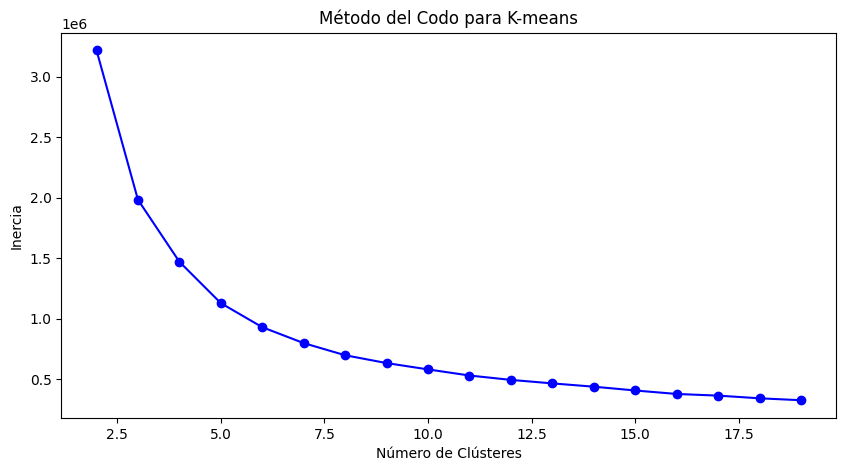

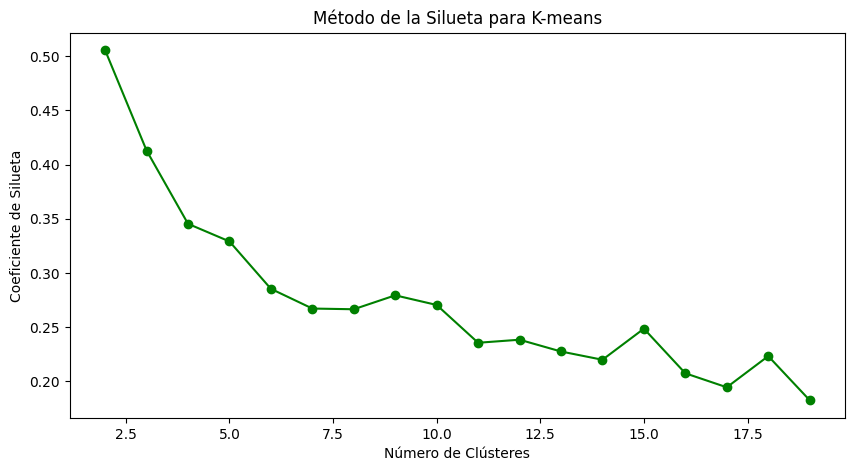

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Rango de clústeres a probar
cluster_range = range(2, 20)  # Puedes ajustar el rango según tus necesidades

inertia_values = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(dtw_distances)
    
    inertia_values.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(dtw_distances, labels, metric="precomputed"))

# Gráfica del método del codo
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel("Número de Clústeres")
plt.ylabel("Inercia")
plt.title("Método del Codo para K-means")
plt.show()

# Gráfica del coeficiente de silueta
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')
plt.xlabel("Número de Clústeres")
plt.ylabel("Coeficiente de Silueta")
plt.title("Método de la Silueta para K-means")
plt.show()

### Gaussian Mixture

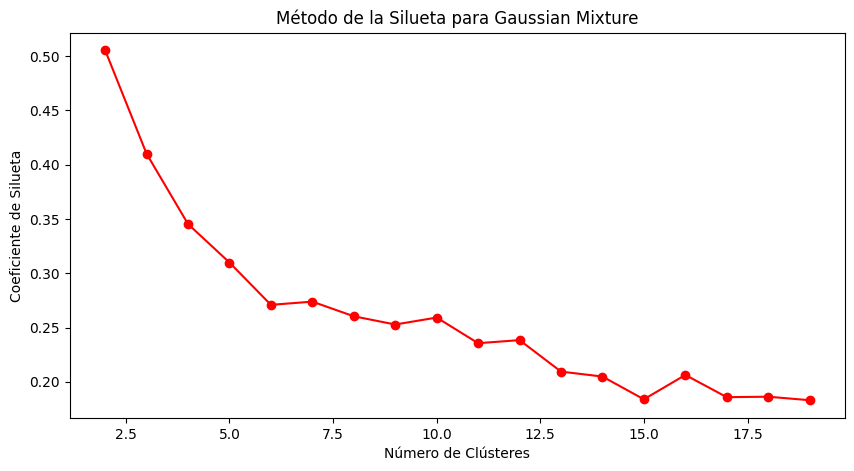

In [47]:
silhouette_scores_gmm = []

for k in cluster_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(dtw_distances)
    labels = gmm.predict(dtw_distances)
    silhouette_scores_gmm.append(silhouette_score(dtw_distances, labels, metric="precomputed"))

plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores_gmm, marker='o', linestyle='-', color='r')
plt.xlabel("Número de Clústeres")
plt.ylabel("Coeficiente de Silueta")
plt.title("Método de la Silueta para Gaussian Mixture")
plt.show()


### BIRCH

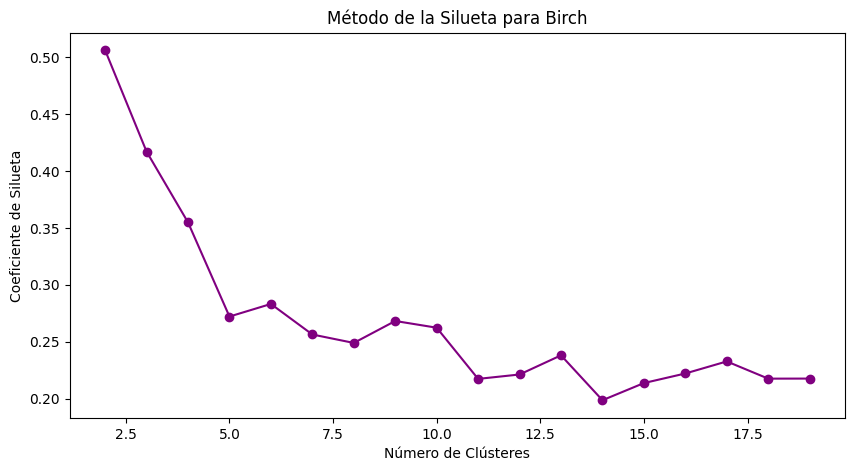

In [48]:
silhouette_scores_birch = []

for k in cluster_range:
    birch = Birch(n_clusters=k)
    birch.fit(dtw_distances)
    labels = birch.predict(dtw_distances)
    silhouette_scores_birch.append(silhouette_score(dtw_distances, labels, metric="precomputed"))

plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores_birch, marker='o', linestyle='-', color='purple')
plt.xlabel("Número de Clústeres")
plt.ylabel("Coeficiente de Silueta")
plt.title("Método de la Silueta para Birch")
plt.show()
